### Add path to structure learning library (skip if installed via pip)

In [1]:
import sys
sys.path.append('../src')

### Import relevant classes, set random seed

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from structure_learning.data import SyntheticDataset, Data
from structure_learning.data_structures import DAG
from structure_learning.scores import BGeScore
from structure_learning.distributions import Distribution
from structure_learning.experiments import Experiment
from structure_learning.evaluation.metrics import RHat, MSE
# for reproducibility
np.random.seed(100)

### 1. Setup experiment by defining an instance of Experiment class

In [3]:
# setup synthetic data
num_nodes = 5
node_labels = [chr(ord('a') + i) for i in range(num_nodes)]
num_obs = 200
degree = 2

synthetic_data = SyntheticDataset(num_nodes=num_nodes, num_obs=num_obs, node_labels=node_labels, degree=degree)
synthetic_data.data.values.to_csv('test.csv')

00010 00100 10000 00000 01010


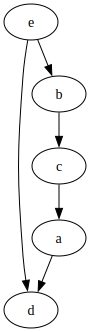

In [4]:
# visualise ground truth DAG
synthetic_data.graph.plot()

In [5]:
true_dist = Distribution.compute_distribution(data=synthetic_data.data, score=BGeScore, graph_type='dag')

np.save('true_distribution.npy', true_dist)

In [6]:

np.save('cpdag.npy', synthetic_data.graph.to_cpdag())

#### configurations of samplers to run

In [7]:
samplers = [
    {
        "sampler_type": "StructureMCMC",
        "n_chains": 2,
        "seeds": [1990, 1981],
        "config": {
            "max_iter": 100000,
            "score_object": "bge",
            "pc_init": False,
            "result_type": "opad",
            "graph_type": "dag",
        }
    },
    {
        "sampler_type": "StructureMCMC",
        "n_chains": 1,
        "seeds": [1990],
        "config": {
            "max_iter": 100000,
            "score_object": "bge",
            "pc_init": False,
            "result_type": "opad+",
            "graph_type": "dag",
        }
    },
    {
        "sampler_type": "PartitionMCMC",
        "n_chains": 2,
        "seeds": [1990, 1981],
        "config": {
            "max_iter": 100000,
            "score_object": "bge",
            "result_type": "opad",
            "graph_type": "dag",
            "searchspace": "FULL"
        }
    }
]

#### run the experiment

In [8]:
exp = Experiment(experiment_name='test', data=synthetic_data.data, samplers=samplers, ground_truth='true_distribution.npy', metrics=['mae', 'mse', 'rhat', 'kld', 'jsd'], n_threads=8, seed=42, snapshot_interval=10000)
res = exp.run()

MCMC iterations:  21%|██        | 20974/100000 [00:02<00:13, 5925.03iter/s]

Adding rejected particles


MCMC iterations:   9%|▉         | 9287/100000 [00:04<00:41, 2184.70iter/s]]

Adding rejected particles


MCMC iterations:  13%|█▎        | 12539/100000 [00:05<00:41, 2102.51iter/s]

Adding rejected particles


MCMC iterations:  16%|█▌        | 15747/100000 [00:07<00:39, 2116.01iter/s]

Adding rejected particles


MCMC iterations:  19%|█▊        | 18729/100000 [00:08<00:38, 2131.57iter/s]

Adding rejected particles


MCMC iterations:  22%|██▏       | 21944/100000 [00:10<00:36, 2127.37iter/s]

Adding rejected particles


MCMC iterations:  80%|███████▉  | 79815/100000 [00:11<00:02, 6919.45iter/s]

Adding rejected particles


MCMC iterations:  92%|█████████▏| 91558/100000 [00:13<00:01, 6515.04iter/s]

Adding rejected particles


MCMC iterations: 100001iter [00:14, 6882.35iter/s]                         
MCMC iterations: 100001iter [00:14, 6865.20iter/s]                         
MCMC iterations: 100001iter [00:14, 6795.53iter/s]                         
MCMC iterations:  31%|███       | 31223/100000 [00:14<00:33, 2057.42iter/s]

Adding rejected particles
Adding rejected particles


MCMC iterations: 100001iter [00:46, 2136.44iter/s]                         
MCMC iterations: 100001iter [00:46, 2131.07iter/s]                         


#### evaluate

/Users/165421/Documents/code/structure_learning/examples/../src/structure_learning/evaluation/metrics.py:276: RuntimeWarning: invalid value encountered in scalar divide
  Rhat = np.sqrt(v/W)


<Figure size 640x480 with 0 Axes>

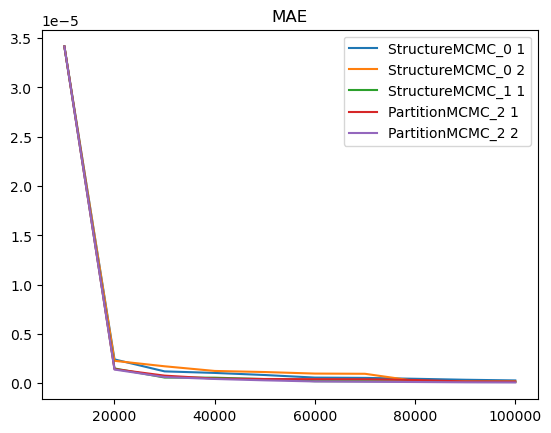

<Figure size 640x480 with 0 Axes>

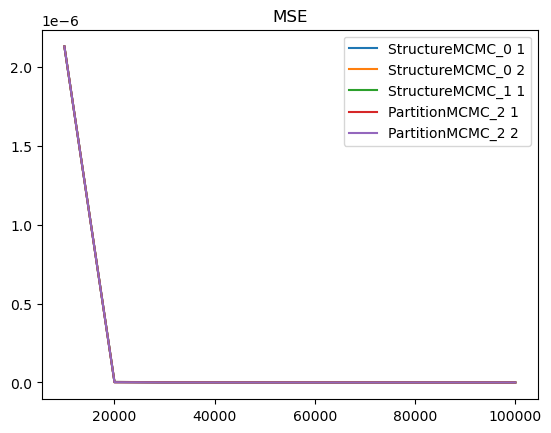

/Users/165421/Documents/code/structure_learning/examples/../src/structure_learning/experiments/experiment.py:77: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


<Figure size 640x480 with 0 Axes>

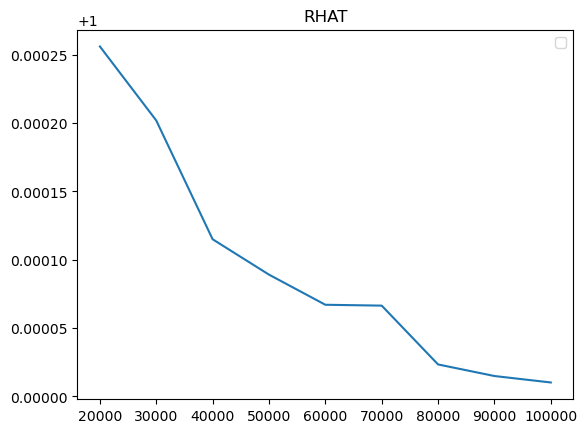

<Figure size 640x480 with 0 Axes>

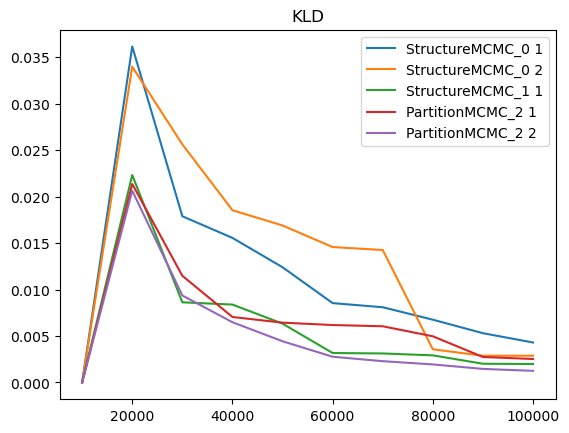

<Figure size 640x480 with 0 Axes>

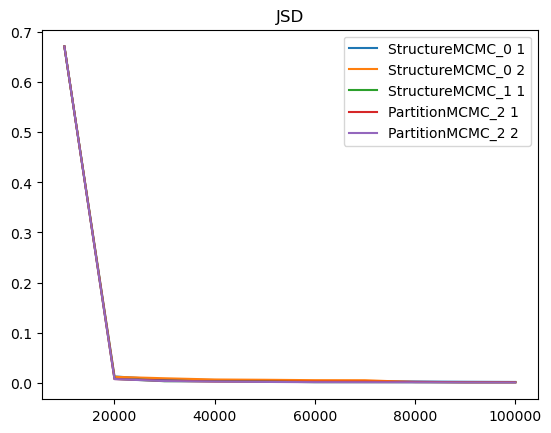

{10000: {'mae': [3.415183907653428e-05,
   3.415183907653428e-05,
   3.415183907653428e-05,
   3.415183907653428e-05,
   3.415183907653428e-05],
  'mse': [2.1319542016430965e-06,
   2.1319542016430965e-06,
   2.1319542016430965e-06,
   2.1319542016430965e-06,
   2.1319542016430965e-06],
  'rhat': [nan],
  'kld': [-1.1251229790164298e-06,
   -1.1251229790164298e-06,
   -1.1251229790164298e-06,
   -1.1251229790164298e-06,
   -1.1251229790164298e-06],
  'jsd': [0.6714307271173425,
   0.6714307271173425,
   0.6714307271173425,
   0.6714307271173425,
   0.6714307271173425]},
 20000: {'mae': [2.424602456598955e-06,
   2.2812948875271754e-06,
   1.5072002785792933e-06,
   1.4428511036961134e-06,
   1.394719842012381e-06],
  'mse': [3.721306617198852e-09,
   3.3945820614396654e-09,
   1.785760791316489e-09,
   1.1831058516267292e-09,
   1.438406295490816e-09],
  'rhat': [1.0002560299093597],
  'kld': [0.03614184482998631,
   0.03396893403879955,
   0.02231251407088696,
   0.021349564130424405,

In [9]:
sampler_types = [f'{sampler['sampler_type']}_{idx} {i+1}' for idx, sampler in enumerate(samplers) for i in range(sampler.get('n_chains', 1))]
exp.evaluate(plot=True, plot_labels=sampler_types)

#### plot distributions

/Users/165421/Documents/code/structure_learning/examples/../src/structure_learning/distributions/distribution.py:218: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(a_melt['index'], rotation=90)


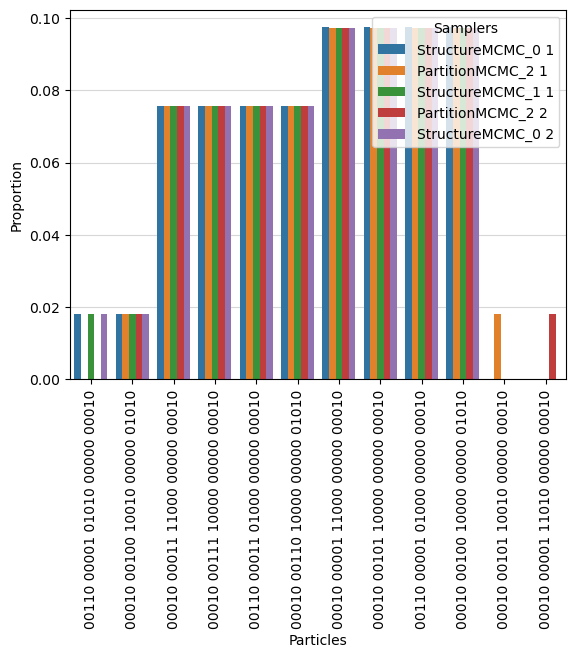

In [10]:
_ = Distribution.plot_multiple([r[0][-1][0] for r in res], prop='p', labels=sampler_types, limit=10)

In [11]:
### create yaml file for the experiment
yaml_content = exp.to_yaml('test.yaml')

### run experiment from yaml configuration

In [12]:
import pandas as pd

exp2 = Experiment.from_yaml('test.yaml', data=synthetic_data.data, ground_truth='true_distribution.npy')
res2 = exp2.run()
exp2.evaluate()

{'experiment_name': 'test', 'ground_truth': 'true_distribution.npy', 'metrics': ['mae', 'mse', 'rhat', 'kld', 'jsd'], 'n_threads': 8, 'samplers': [{'config': {'graph_type': 'dag', 'initial_state': None, 'max_iter': 100000, 'pc_ci_test': 'pearsonr', 'pc_init': False, 'pc_significance_level': 0.01, 'proposal_object': 'graph', 'result_type': 'opad', 'score_object': 'BGeScore', 'seed': 1990, 'sparse': True}, 'sampler_type': 'StructureMCMC'}, {'config': {'graph_type': 'dag', 'initial_state': None, 'max_iter': 100000, 'pc_ci_test': 'pearsonr', 'pc_init': False, 'pc_significance_level': 0.01, 'proposal_object': 'graph', 'result_type': 'opad', 'score_object': 'BGeScore', 'seed': 1981, 'sparse': True}, 'sampler_type': 'StructureMCMC'}, {'config': {'graph_type': 'dag', 'initial_state': None, 'max_iter': 100000, 'pc_ci_test': 'pearsonr', 'pc_init': False, 'pc_significance_level': 0.01, 'proposal_object': 'graph', 'result_type': 'opad+', 'score_object': 'BGeScore', 'seed': 1990, 'sparse': True}, '

MCMC iterations:  20%|██        | 20226/100000 [00:02<00:12, 6338.49iter/s]

Adding rejected particles


MCMC iterations:  10%|▉         | 9547/100000 [00:04<00:42, 2130.93iter/s]]

Adding rejected particles


MCMC iterations:  41%|████▏     | 41301/100000 [00:06<00:09, 6158.94iter/s]

Adding rejected particles


MCMC iterations:  15%|█▌        | 15464/100000 [00:07<00:42, 1981.29iter/s]

Adding rejected particles


MCMC iterations:  20%|█▉        | 19529/100000 [00:09<00:38, 2111.00iter/s]

Adding rejected particles


MCMC iterations:  22%|██▏       | 22044/100000 [00:10<00:38, 2005.21iter/s]

Adding rejected particles


MCMC iterations:  82%|████████▏ | 82338/100000 [00:12<00:02, 6462.86iter/s]

Adding rejected particles


MCMC iterations:  93%|█████████▎| 92541/100000 [00:13<00:01, 6504.24iter/s]

Adding rejected particles


MCMC iterations: 100001iter [00:15, 6613.41iter/s]                         
MCMC iterations: 100001iter [00:15, 6609.22iter/s]                         
MCMC iterations:  32%|███▏      | 31538/100000 [00:15<00:32, 2082.73iter/s]

Adding rejected particles
Adding rejected particles


MCMC iterations: 100001iter [00:15, 6422.51iter/s]                         
MCMC iterations: 100001iter [00:47, 2121.99iter/s]                         
MCMC iterations: 100001iter [00:48, 2067.80iter/s]                         
/Users/165421/Documents/code/structure_learning/examples/../src/structure_learning/evaluation/metrics.py:276: RuntimeWarning: invalid value encountered in scalar divide
  Rhat = np.sqrt(v/W)


{10000: {'mae': [3.415183907653428e-05,
   3.415183907653428e-05,
   3.415183907653428e-05,
   3.415183907653428e-05,
   3.415183907653428e-05],
  'mse': [2.1319542016430965e-06,
   2.1319542016430965e-06,
   2.1319542016430965e-06,
   2.1319542016430965e-06,
   2.1319542016430965e-06],
  'rhat': [nan],
  'kld': [-1.1251229790164298e-06,
   -1.1251229790164298e-06,
   -1.1251229790164298e-06,
   -1.1251229790164298e-06,
   -1.1251229790164298e-06],
  'jsd': [0.6714307271173425,
   0.6714307271173425,
   0.6714307271173425,
   0.6714307271173425,
   0.6714307271173425]},
 20000: {'mae': [2.424602456598955e-06,
   2.2812948875271754e-06,
   1.5072002785792933e-06,
   1.2330078808086394e-06,
   2.102435049616243e-06],
  'mse': [3.721306617198852e-09,
   3.3945820614396654e-09,
   1.785760791316489e-09,
   9.889755318459776e-10,
   3.2282820598712134e-09],
  'rhat': [1.0002522625914099],
  'kld': [0.03614184482998631,
   0.03396893403879955,
   0.02231251407088696,
   0.018215994336119805,